In [5]:
import os
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
from scipy.misc import imread
import matplotlib.pyplot as plt

from math import *
import cv2
import keras.backend as K

import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
tf.python.control_flow_ops = control_flow_ops

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, InputLayer, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Flatten, SpatialDropout2D, Cropping2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image

from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.models import model_from_json

%matplotlib inline

Using TensorFlow backend.


In [6]:
def image_generator(driving_log, data_path, normalizer=255.0, steering_shift=1.5, steering_max=25.):
    driving_log = driving_log.sample(frac=1).reset_index(drop=True)

    for index, row in driving_log.iterrows():
        fname  = os.path.basename(row['center'])
        fname1 = os.path.basename(row['left'])
        fname2 = os.path.basename(row['right'])
            # Normalized YUV
#         img  = imread(data_path+'IMG/'+fname, False, 'YCbCr').astype(np.float32)
#         img1 = imread(data_path+'IMG/'+fname1, False, 'YCbCr').astype(np.float32)
#         img2 = imread(data_path+'IMG/'+fname2, False, 'YCbCr').astype(np.float32)
#         img  = imread(data_path+'IMG/'+fname).astype(np.float32)
#         img1 = imread(data_path+'IMG/'+fname1).astype(np.float32)
#         img2 = imread(data_path+'IMG/'+fname2).astype(np.float32)

        img = load_img(data_path+'IMG/'+fname)
        img1 = load_img(data_path+'IMG/'+fname1)
        img2 = load_img(data_path+'IMG/'+fname2)
        img = cv2.cvtColor(img_to_array(img), cv2.COLOR_RGB2YUV)
        img1 = cv2.cvtColor(img_to_array(img1), cv2.COLOR_RGB2YUV)
        img2 = cv2.cvtColor(img_to_array(img2), cv2.COLOR_RGB2YUV)
        
        yield img, np.float32(row['steering'])
        yield img1, np.float32(row['steering'])+steering_shift/steering_max
        yield img2, np.float32(row['steering'])-steering_shift/steering_max
        
        if abs(np.float32(row['steering'])) >= 1/25.:
            yield np.fliplr(img), -np.float32(row['steering'])
        
#         if abs(np.float32(row['steering'])-steering_shift/steering_max) > 1./25.:
#             yield np.fliplr(img2), -(np.float32(row['steering'])-steering_shift/steering_max)

#         if abs(np.float32(row['steering'])+steering_shift/steering_max) > 1./25.:
#             yield np.fliplr(img1), -(np.float32(row['steering'])+steering_shift/steering_max)
        
def batch_generator(driving_log, data_path, batch_size=32, *args, **kwargs):
    num_rows = len(driving_log.index)
    train_images = np.zeros((batch_size, img_rows, img_cols, 3))
    train_steering = np.zeros(batch_size)
    ctr = None
    while 1:        
        for j in range(batch_size):
            # Reset generator if over bounds
            if ctr is None or ctr >= num_rows:
                ctr = 0
                images = image_generator(driving_log, data_path, *args, **kwargs)
            train_images[j], train_steering[j] = next(images)
            ctr += 1
        yield train_images, train_steering

In [7]:
data_path = './driving-data/'
test_path = './test-data/'

img_rows, img_cols = 160, 320
# img_rows, img_cols = 66, 200

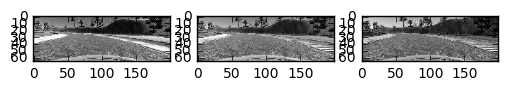

In [8]:
fname = 'center_2016_11_27_18_07_19_151.jpg'
# im = imread(data_path+'IMG/'+fname).astype(np.float32)
im = load_img(data_path+'IMG/'+fname, False, (66, 200))
im = img_to_array(im)
# im = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)
# im = normalize_color(im)

# plt.figure()
# plt.imshow(im)
# plt.figure()
# plt.imshow(np.fliplr(im))
# plt.show()
# im2 = cv2.cvtColor(imread(data_path+'IMG/'+fname).astype(np.float32), cv2.COLOR_RGB2YUV)
plt.subplot(1,3,1)
plt.imshow(im[:,:,0], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(im[:,:,1], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(im[:,:,2], cmap='gray')
plt.show()

In [9]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
driving_log = pd.read_csv(data_path+'driving_log.csv', names=columns)
driving_log = driving_log.sample(frac=1).reset_index(drop=True) # Shuffle

test_log = pd.read_csv(test_path+'driving_log.csv', names=columns)
test_log = test_log.sample(frac=1).reset_index(drop=True) # Shuffle

train_data = batch_generator(driving_log, data_path, batch_size=32)
val_data = batch_generator(test_log.sample(frac=0.1), test_path, batch_size=32)
test_data = batch_generator(test_log.sample(frac=0.9), test_path, batch_size=32)
print(len(driving_log))
print(len(test_log))

8810
1692


In [26]:
new_shape = (66, 200)

model = Sequential()
# Crop out 60:140,40:280 from 160x320 image (hxw)
model.add(Cropping2D(cropping=((60, 20), (39,39)), input_shape=(img_rows, img_cols, 3)))
model.add(Lambda(lambda x:tf.image.resize_images(x, new_shape)))
model.add(Lambda(lambda x: x/127.5 - 1.))  # Normalization courtesy of John Chen
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu', name='Conv1'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu', name='Conv2'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu', name='Conv3'))
model.add(Convolution2D(64, 3, 3, activation='relu', name='Conv4'))
model.add(Convolution2D(64, 3, 3, activation='relu', name='Conv5'))
model.add(Flatten())
model.add(Dense(1164, activation='relu', name='FC1'))
model.add(Dense(100, activation='relu', name='FC2'))
model.add(Dense(50, activation='relu', name='FC3'))
model.add(Dense(10, activation='relu', name='FC4'))
model.add(Dense(1, name='output'))
# model.summary()

In [27]:
# with open('./model_5a.json', 'r') as json_file:
#     model = model_from_json(json_file.read())

# model.load_weights('./model_5a.h5')
# # model.summary()

In [28]:
def driving_acc(y_true, y_pred, threshold = 0.5/25.):
    """
    Shows what percentage of the batch are within 0.5 deg of true data
    """
    
    diff = K.abs(y_true - y_pred)
    good_rows = K.lesser(diff, threshold)
    good = K.sum(K.cast(good_rows, K.floatx()))
    total = K.sum(K.ones_like(y_true))
    return good*100/total

In [29]:
opt = Adam(lr=0.001)
# opt = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='mse', metrics=[])

In [30]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        print('BEGIN TRAINING')
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [ ]:
batch_history = LossHistory()
# 6 epochs of 40k
h = model.fit_generator(train_data, validation_data = val_data,
                        samples_per_epoch = 40000,
                        nb_val_samples = 960,
                        nb_epoch=2, verbose=1, callbacks=[batch_history]) # low initial loss = bad

BEGIN TRAINING
Epoch 1/2
 6496/40000 [===>..........................] - ETA: 92s - loss: 0.0417

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

def plot_history(history):
    plt.plot(running_mean(history.losses, 50))
    plt.ylim(0, 0.06)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batches')
    plt.show()
    
plot_history(batch_history)

In [ ]:
test_loss = model.evaluate_generator(test_data, 2000)
print(test_loss)

In [ ]:
model_json = model.to_json()
model_name = 'model_5'
with open(model_name+'.json', "w") as json_file:
    json_file.write(model_json)

model.save_weights(model_name+'.h5')

In [23]:
model2 = Model(input=model.input, output=model.get_layer('Conv1').output)

# with open('model_4a.json', "r") as json_file:
#     model4 = model_from_json(json_file.read())
# model4.load_weights('model_4a.h5')

img_path = 'driving-data/IMG/center_2016_11_27_23_18_14_417.jpg'
img = load_img(data_path+'IMG/'+fname)
img = cv2.cvtColor(img_to_array(img), cv2.COLOR_RGB2YUV)
x = img
# plt.imshow(x[:,:,0], cmap='gray')
x = np.expand_dims(x, axis=0)

conv4_features = model2.predict(x)
angle = model.predict(x)
print((angle)*25)

# # print(angle*25)
# img2 = imread(data_path+'IMG/'+fname, False, 'YCbCr').astype(np.float32)
# x2 = normalize_color(img2)
# x2 = np.expand_dims(x2, axis=0)
# angle2 = model4.predict(x2)

# print((angle2*2-1)*25)
print(conv4_features.shape)
# with open('./model_4a.json', 'r') as json_file:
#     model_json = model_from_json(json_file.read())

# model_json.load_weights('./model_4a.h5')
# model_json.summary()

[[-3.49712324]]
(1, 31, 98, 24)


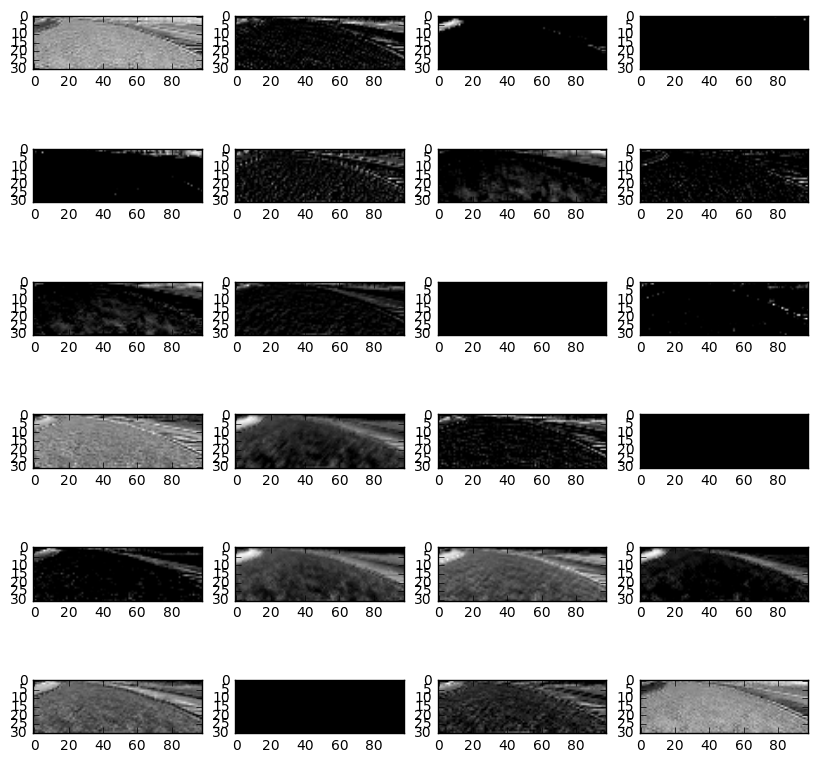

In [24]:
plt.rcParams["figure.figsize"] = (10,10)
plt.figure()
for i in range(24):
    plt.subplot(6, 4, i+1)
    plt.imshow(conv4_features[0,:,:,i], cmap='gray')
plt.show()

In [ ]:
# from keras.applications import VGG16
# vgg = VGG16(weights='imagenet', include_top=False)

In [ ]:
# vgg.summary()

In [ ]:
# plt.rcParams["figure.figsize"] = (10,10)

# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input

# model2 = Model(input=vgg.input, output=vgg.get_layer('block3_pool').output)
    
# img_path = 'driving-data/IMG/center_2016_11_27_23_18_18_813.jpg'
# img = image.load_img(img_path, target_size=(224, 224))

# x = image.img_to_array(img)

# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# block4_pool_features = model2.predict(x)
# print(block4_pool_features.shape)

# # plt.figure()
# # for i in range(16):
# #     plt.subplot(4, 4, i+1)
# #     plt.imshow(block4_pool_features[0,:,:,16+i])
    
# # plt.show()

In [ ]:
# model2.layers[0] = InputLayer(input_shape=(224,224,3), input_dtype=np.float32)

# for l in model2.layers:
#     l.trainable=False
    
# model = Sequential(model2.layers)#, input_shape=(12, 40, 256))  # 20,40,256
# model.add(Convolution2D(24, 5, 5))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Convolution2D(36, 5, 5))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Dropout(0.5))

# model.add(Convolution2D(48, 5, 5))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Convolution2D(64, 3, 3))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Convolution2D(64, 3, 3))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Flatten())
# model.add(Dense(1154))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dense(100))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dense(50))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dense(10))
# model.add(BatchNormalization())
# model.add(Activation('sigmoid'))
# model.add(Dense(1))

In [ ]:
# X1_train, y1_train = load_data(normalizer=1.0, vgg=True)
# X_train, X_val, y_train, y_val = train_test_split(X1_train, y1_train, test_size=0.05, random_state=0xdeadbeef)
# del X1_train, y1_train
# X2_train = preprocess_input(X_train)
# X2_val = preprocess_input(X_val)

In [ ]:
# opt = Adam(lr=1e-3)
# model.compile(optimizer=opt, loss='mae')
# model.predict(x)

In [ ]:
# h = model.fit(X2_train, y_train, batch_size=35, nb_epoch=10,
#     validation_data=(X2_val, y_val), verbose=1)

In [ ]:
# model_json = model.to_json()
# model_name = 'vgg_01'
# with open(model_name+'.json', "w") as json_file:
#     json_file.write(model_json)

# model.save_weights(model_name+'.h5')

In [ ]:
# model.predict(X2_train[0:10,:])